In [8]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
%matplotlib inline

#1)Ici, on va appliquer la régularisation sur la régression logistique.

def normaliser(X, mean=None, std=None): 
    if (mean is None) or (std is None): 
        mean = np.mean(X, axis=0)
        std = np.std(X, axis=0)
    X_norm = (X - mean)/std
    return X_norm, mean, std

# Préparer la matrice des caractéristiques pour l'entrainnement ou la prédiction
# On applique la normalisation sur chaque colonne (sauf si : norm=False)
# Ensuite on ajoute une colonne des 1 (sauf si : const=False)
def preparer(X, norm=True, const=True, mean=None, std=None): 
    X_pre = X.copy()
    if norm: 
        X_pre, mean, std = normaliser(X_pre, mean=mean, std=std)
    if const:
        X_pre = np.append(np.ones((X_pre.shape[0],1)), X_pre ,axis=1)
    return X_pre, mean, std

# Défininir des fonctions qui génèrent des vecteurs ou des matrices
# Ces fonctions seront utilisées pour générer les Thétas

def generer_zeros_1(nbr):
    return np.zeros(nbr)

def generer_uns_1(nbr):
    return np.ones(nbr)

def generer_aleatoire_1(nbr):
    return np.random.rand(nbr)

def afficher_2(X, Y, L=None, Y_labels=["Admis", "Non admis"], X_labels=["Note 1", "Note 2"]):
    oui = Y == 1
    plt.scatter(X[oui, 0], X[oui, 1], color="green", marker="o", label=Y_labels[0])
    plt.scatter(X[~oui, 0], X[~oui, 1], color="red", marker="x", label=Y_labels[1])
    if L is not None:
        x_values, y_values = L
        plt.plot(x_values, y_values, label="ligne de decision")
    plt.xlabel(X_labels[0])
    plt.ylabel(X_labels[1])
    plt.legend()
    plt.show()
    
# th0 + th1 * x1 + th2 * x2 = 0
def ligne_decision(X, Theta, mean=[0, 0], std=[1, 1]):
    X1 = [np.min(X[:,0]), np.max(X[:,0])]
    X2_min = mean[1] - std[1] * (Theta[0] + Theta[1] * (X1[0] - mean[0])/std[0]) / Theta[2]
    X2_max = mean[1] - std[1] * (Theta[0] + Theta[1] * (X1[1] - mean[0])/std[0]) / Theta[2]
    return X1, [X2_min, X2_max]

# La fonction qui calcule la combination linéaire entre les caractéristiques
# Vous l'avez déjà vu dans la régression linéaire
def z_1(X, Theta): 
    return np.dot(X, Theta)

# La fonction ségmoid
# Elle doit fonctionner sur des scalaires ou des vecteurs de numpy
def sigmoid(X):
    # Fonction d'activation utilisée pour rendre les valeurs réelles entre 0 et 1 
    return  1 / (1 + np.exp(-X))

def h_1(X, Theta, mean=None, std=None, const=False): 
    norm = (mean is not None) and (std is not None)
    X_pre, mean, std = preparer(X, norm, const, mean=mean, std=std)
    return sigmoid(z_1(X_pre, Theta))


def J(H, Y): 
    return - np.mean(Y * np.log(H) + (1-Y) * np.log(1-H))  

# TODO compléter la fonction du coût avec régularisation L2
def J_L2(H, Y, Theta, Lambda=0.):
    return J(H, Y) + Lambda * np.sum(Theta**2)/(2*len(Y))

def gradient(X, H, Y):
    return  np.dot(X.T, H-Y)/float(len(Y))

# TODO compléter la fonction du gradient avec régularisation L2
# Ici, on peut ne pas utiliser H comme paramètre puisqu'on peut le calculer
# en utilisant X et theta
# Mais, on le fait pour ne pas recalculer H deux fois lors de la descente du gradient 
def gradient_L2(X, H, Y, Theta, Lambda=0.):
    return  gradient(X, H, Y) + Lambda/len(Y) * Theta

def entrainer_L2(X, Y, norm=True, const=True, nbr_iter=200, alpha=0.1, Lambda=0.1, eps=0.01): 
    
    X_pre, mean, std = preparer(X, norm, const)
    Theta = generer_uns_1(X_pre.shape[1])
    
    couts = []
    thetas = []
    
    for i in range(nbr_iter):
        H = h_1(X_pre, Theta)
        Theta -= alpha * gradient_L2(X_pre, H, Y, Theta, Lambda=Lambda)
        couts.append(J_L2(H, Y, Theta, Lambda=Lambda))
        thetas.append(list(Theta))#pour ne pas ajouter la même référence vers le tableau
        #print(Theta)
        """if i > 1 and abs(couts[-1] - couts[-2]) <= eps:
            return thetas, mean, std, couts"""
        """if i > 1 and couts[-1] > couts[-2] :
            couts.pop()
            thetas.pop()
            return thetas, mean, std, couts"""
    
    return thetas, mean, std, couts

def J_L1(H, Y, Theta, Lambda=0.):
    return J(H, Y) + Lambda * np.sum(np.abs(Theta))/(len(Y))

def S(Theta, Lambda): 
    return np.where(Theta < -Lambda, Theta+Lambda, np.where(Theta > Lambda, Theta-Lambda, 0))

def entrainer_L1(X, Y, norm=True, const=True, nbr_iter=200, alpha=0.1, Lambda=0.1, eps=0.01): 
    
    X_pre, mean, std = preparer(X, norm, const)
    Theta = generer_uns_1(X_pre.shape[1])
    m = len(X_pre)
    
    couts = []
    thetas = []

    for i in range(nbr_iter):
        H = h_1(X_pre, Theta)
        Theta = S(Theta - alpha * gradient(X_pre, H, Y), Lambda/m)
        couts.append(J_L1(H, Y, Theta, Lambda=Lambda))
        thetas.append(list(Theta)) #pour ne pas ajouter le même référence vers le tableau
        #print(couts[-1])
        """if i > 1 and couts[-1] > couts[-2] :
            couts.pop()
            thetas.pop()
            return thetas, mean, std, couts"""
        
        """if i > 1 and abs(couts[-1] - couts[-2]) <= eps:
            return thetas, mean, std, couts"""
    
    return thetas, mean, std, couts

class RegLogReg(object): # Régression logistique régularisée
    
    def __init__(self, nbr_iter=100, alpha=.01, Lambda=0.01, norm=True, const=True, reg="l2"): 
        self.nbr_iter = nbr_iter
        self.alpha = alpha
        self.Lambda = Lambda
        self.norm = norm
        self.const = const
        self.reg = reg
    
    def entrainer(self, X, Y): 
        if self.reg == "l1":
            entrainer = entrainer_L1
        else:
            entrainer = entrainer_L2
            
        self.thetas, self.mean, self.std, self.couts = entrainer(X, Y, 
                                                                  nbr_iter=self.nbr_iter, 
                                                                  alpha=self.alpha, 
                                                                  Lambda=self.Lambda, 
                                                                  norm=self.norm, 
                                                                  const=self.const)
        
    # La prédiction
    # si prob=True elle rend un vecteur de probabilités
    # sinon elle rend une vecteur de 1 et 0
    def predire(self, X, prob=False, seuil=0.5, it=-1):
        H = h_1(X, self.thetas[it], self.mean, self.std, self.const)
        if prob:
            return H
        return (H >= seuil).astype(int)
    
    
#-----------------------------ANOVA--------------------------------------------------------

def f_oneway(A): 
    # A est une liste de N listes où N est le nombre des classes
    # Ces listes n'ont pas la même taille
    nbrs = np.array([len(a) for a in A]) # nombre des échantillons de chaque classe
    sommes = np.array([np.sum(a) for a in A]) # somme des valeurs de chaque classe
    sommes_caree = np.sum([np.sum(np.array(a)**2) for a in A]) # somme des valeurs carrées de toutes les valeurs
    
    # Compléter ici
    #====================================
    CF = (sommes.sum())**2/nbrs.sum()
    TotalSS = sommes_caree - CF
    TreatmentSS = np.sum(sommes**2/nbrs) - CF
    ErrorSS = TotalSS - TreatmentSS
    #====================================
    
    MSB = TreatmentSS / (len(A) - 1) 
    MSW =  ErrorSS/(nbrs.sum() - len(A))
    return MSB/MSW

def anova_f(X, Y): 
    
    C = np.unique(Y)
    F = []
    for j in range(X.shape[1]): 
        A = X[:, j]
        F.append(f_oneway([A[Y==c] for c in np.unique(Y)]))
    return F

In [3]:
diabetes = pd.read_csv("datasets/diabetes2.csv") 
X_diabetes = diabetes.iloc[:, :-1].values  
Y_diabetes = diabetes.iloc[:, -1].values

# Cette configuration est mise en place comme ceci exprès
# C'est pour tester le cas où la régression est difavorisée
NBR_TEST = 240
# Supposant que les 30% premières lignes sont pour le test et le reste pour l'entraînement
X_test = X_diabetes[-NBR_TEST:, :] # 30% ou plus
Y_test = Y_diabetes[-NBR_TEST:]

X_train = X_diabetes[:-NBR_TEST, :] 
Y_train = Y_diabetes[:-NBR_TEST]


ALPHA = .2
LAMBDA = 20.
NBR_ITER=100

reg2log_L2 = RegLogReg(alpha=ALPHA, Lambda=LAMBDA, nbr_iter=NBR_ITER, const=True) # par défaut reg="L2"
reg2log_L2.entrainer(X_train, Y_train)

reg2log_L1 = RegLogReg(reg="l1", alpha=ALPHA, Lambda=LAMBDA, nbr_iter=NBR_ITER, const=True) # L1
reg2log_L1.entrainer(X_train, Y_train)

reg2log = RegLogReg(alpha=ALPHA, Lambda=0, nbr_iter=NBR_ITER, const=True) # L2 avec lambda = 0 devient une regression normale
reg2log.entrainer(X_train, Y_train)


from sklearn.metrics import recall_score, precision_score

recalls_train = {
    "reg" : [],
    "reg-L2": [],
    "reg-L1": []
}

precisions_train = {
    "reg" : [],
    "reg-L2": [],
    "reg-L1": []
}

recalls_test = {
    "reg" : [],
    "reg-L2": [],
    "reg-L1": []
}

precisions_test = {
    "reg" : [],
    "reg-L2": [],
    "reg-L1": []
}

for it in range(NBR_ITER): 
    
    Y_train_reg = reg2log.predire(X_train, it=it)
    Y_train_reg_L2 = reg2log_L2.predire(X_train, it=it)
    Y_train_reg_L1 = reg2log_L1.predire(X_train, it=it)
    
    recalls_train["reg"].append(recall_score(Y_train, Y_train_reg))
    recalls_train["reg-L2"].append(recall_score(Y_train, Y_train_reg_L2))
    recalls_train["reg-L1"].append(recall_score(Y_train, Y_train_reg_L1))
    
    precisions_train["reg"].append(precision_score(Y_train, Y_train_reg))
    precisions_train["reg-L2"].append(precision_score(Y_train, Y_train_reg_L2))
    precisions_train["reg-L1"].append(precision_score(Y_train, Y_train_reg_L1))
    
    Y_test_reg = reg2log.predire(X_test, it=it)
    Y_test_reg_L2 = reg2log_L2.predire(X_test, it=it)
    Y_test_reg_L1 = reg2log_L1.predire(X_test, it=it)
    
    recalls_test["reg"].append(recall_score(Y_test, Y_test_reg))
    recalls_test["reg-L2"].append(recall_score(Y_test, Y_test_reg_L2))
    recalls_test["reg-L1"].append(recall_score(Y_test, Y_test_reg_L1))
    
    precisions_test["reg"].append(precision_score(Y_test, Y_test_reg))
    precisions_test["reg-L2"].append(precision_score(Y_test, Y_test_reg_L2))
    precisions_test["reg-L1"].append(precision_score(Y_test, Y_test_reg_L1))

print("FIN")

FIN


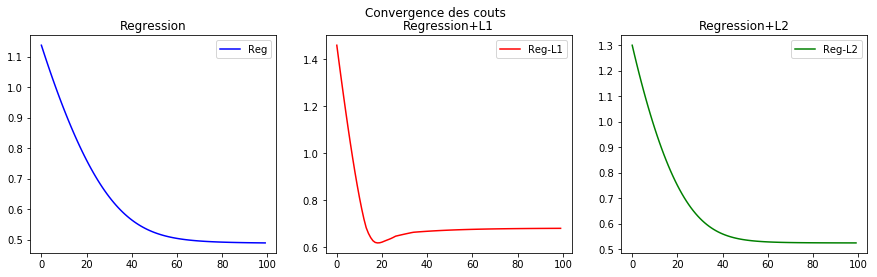

In [4]:
#comparer la rapidite de convergence
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle("Convergence des couts")
fig.set_figwidth(15)
ax1.plot(range(NBR_ITER), reg2log.couts, color="blue", label="Reg")
ax2.plot(range(NBR_ITER), reg2log_L1.couts, color="red", label="Reg-L1")
ax3.plot(range(NBR_ITER), reg2log_L2.couts, color="green", label="Reg-L2")

ax1.legend()
ax1.set_title("Regression")
ax2.legend()
ax2.set_title("Regression+L1")
ax3.legend()
ax3.set_title("Regression+L2")

#plt.plot(range(nbr_it[0]), reg2log.couts, color="blue", label="Reg")
#plt.plot(range(nbr_it[1]), reg2log_L1.couts, color="red", label="Reg-L1")
#plt.plot(range(nbr_it[2]), reg2log_L2.couts, color="green", label="Reg-L2")
#plt.ylabel("Couts")
#plt.xlabel("Iterations")
#plt.legend()
plt.show()

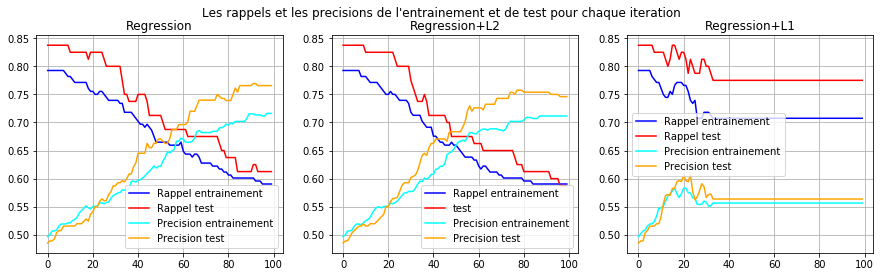

In [5]:
#comparer l'appel et la précision de l'entraînement
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
fig.suptitle("Les rappels et les precisions de l'entrainement et de test pour chaque iteration")
fig.set_figwidth(15)
    
ax1.plot(range(NBR_ITER), recalls_train["reg"], color="blue", label="Rappel entrainement")
ax1.plot(range(NBR_ITER), recalls_test["reg"], color="red", label="Rappel test")
ax1.plot(range(NBR_ITER), precisions_train["reg"], color="cyan", label="Precision entrainement")
ax1.plot(range(NBR_ITER), precisions_test["reg"], color="orange", label="Precision test")
ax1.legend()
ax1.set_title("Regression")
ax1.grid()

ax3.plot(range(NBR_ITER), recalls_train["reg-L1"], color="blue", label="Rappel entrainement")
ax3.plot(range(NBR_ITER), recalls_test["reg-L1"], color="red", label="Rappel test")
ax3.plot(range(NBR_ITER), precisions_train["reg-L1"], color="cyan", label="Precision entrainement")
ax3.plot(range(NBR_ITER), precisions_test["reg-L1"], color="orange", label="Precision test")
ax3.legend()
ax3.set_title("Regression+L1")
ax3.grid()

ax2.plot(range(NBR_ITER), recalls_train["reg-L2"], color="blue", label="Rappel entrainement")
ax2.plot(range(NBR_ITER), recalls_test["reg-L2"], color="red", label="test")
ax2.plot(range(NBR_ITER), precisions_train["reg-L2"], color="cyan", label="Precision entrainement")
ax2.plot(range(NBR_ITER), precisions_test["reg-L2"], color="orange", label="Precision test")
ax2.legend()
ax2.set_title("Regression+L2")
ax2.grid()

plt.show()

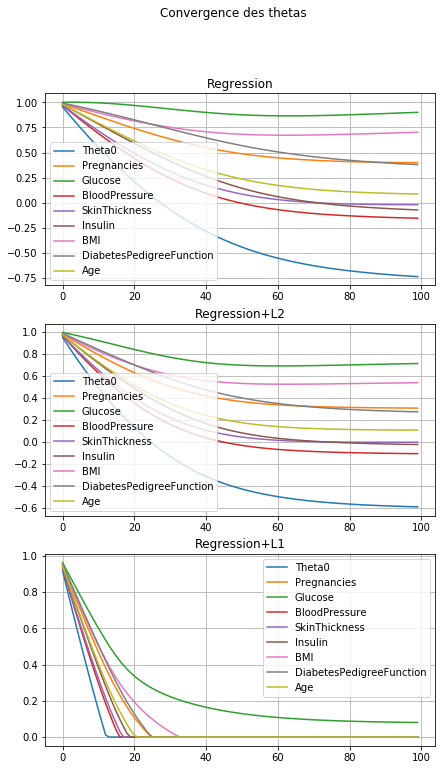

In [6]:
#comparer la convergence des paramètres (thétas)
labels = list(diabetes.columns)
labels.pop()
labels = ["Theta0"] + labels
fig, (ax1, ax2, ax3) = plt.subplots(3,1)
fig.suptitle("Convergence des thetas")
fig.set_figwidth(7)
fig.set_figheight(12)
for i in range(len(labels)): 
    ax1.plot(range(NBR_ITER), np.array(reg2log.thetas)[:, i], label=labels[i])
    ax3.plot(range(NBR_ITER), np.array(reg2log_L1.thetas)[:, i], label=labels[i])
    ax2.plot(range(NBR_ITER), np.array(reg2log_L2.thetas)[:, i], label=labels[i])
ax1.legend()
ax1.set_title("Regression")
ax1.grid()
ax3.legend()
ax3.set_title("Regression+L1")
ax3.grid()
ax2.legend()
ax2.set_title("Regression+L2")
ax2.grid()

plt.show()

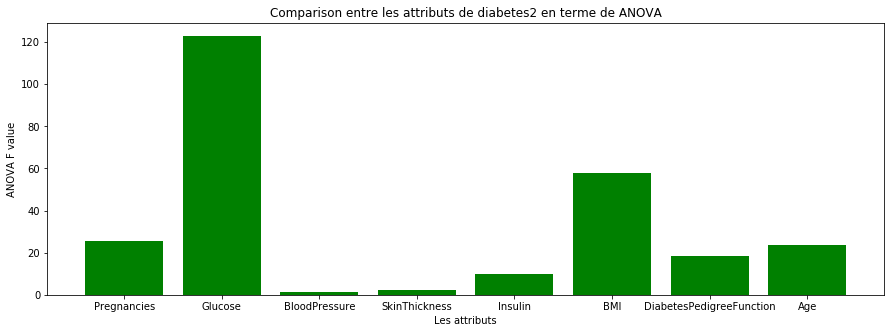

In [9]:
#Comparison entre régression logistique avant et après filtrage (rapidite et convergence)

F_diabetes = anova_f(X_train, Y_train)
labels_diabetes = list(diabetes.columns)
labels_diabetes.pop()
x_pos = range(len(F_diabetes))
plt.figure(figsize=(15,5))
plt.bar(labels_diabetes, F_diabetes, color="green")
plt.xlabel("Les attributs")
plt.ylabel("ANOVA F value")
plt.title("Comparison entre les attributs de diabetes2 en terme de ANOVA")

plt.xticks(x_pos, labels_diabetes)

plt.show()

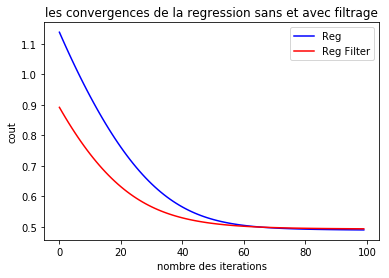

In [10]:
#convergence
select = [True, True, False, False, False, True, True, True]
reg2log_filt = RegLogReg(alpha=ALPHA, Lambda=0, nbr_iter=NBR_ITER, const=True) # L2 avec lambda = 0 devient une regression normale
reg2log_filt.entrainer(X_train[:, select], Y_train)

plt.plot(range(NBR_ITER), reg2log.couts, color="blue", label="Reg")
plt.plot(range(NBR_ITER), reg2log_filt.couts, color="red", label="Reg Filter")
plt.xlabel("nombre des iterations")
plt.ylabel("cout")
plt.legend()
plt.title("les convergences de la regression sans et avec filtrage")

plt.show()

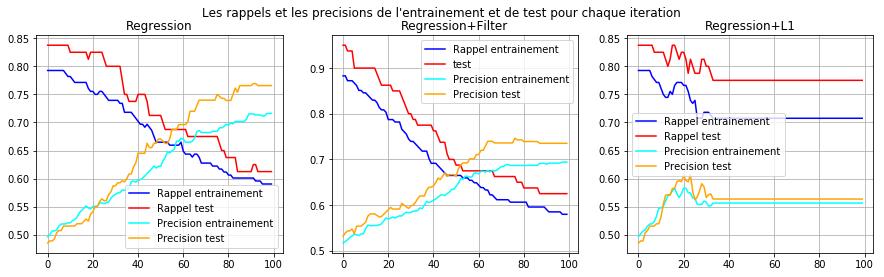

In [11]:
#precision

recalls_train["reg-Filt"] = []
precisions_train["reg-Filt"] = []
recalls_test["reg-Filt"] = []
precisions_test["reg-Filt"] = []

for it in range(NBR_ITER): 
    Y_train_regfilt = reg2log_filt.predire(X_train[:, select], it=it)
    Y_test_regfilt = reg2log_filt.predire(X_test[:, select], it=it)
    recalls_train["reg-Filt"].append(recall_score(Y_train, Y_train_regfilt))
    precisions_train["reg-Filt"].append(precision_score(Y_train, Y_train_regfilt))
    recalls_test["reg-Filt"].append(recall_score(Y_test, Y_test_regfilt))
    precisions_test["reg-Filt"].append(precision_score(Y_test, Y_test_regfilt))


fig, (ax1, ax2, ax3) = plt.subplots(1,3)
fig.suptitle("Les rappels et les precisions de l'entrainement et de test pour chaque iteration")
fig.set_figwidth(15)
    
ax1.plot(range(NBR_ITER), recalls_train["reg"], color="blue", label="Rappel entrainement")
ax1.plot(range(NBR_ITER), recalls_test["reg"], color="red", label="Rappel test")
ax1.plot(range(NBR_ITER), precisions_train["reg"], color="cyan", label="Precision entrainement")
ax1.plot(range(NBR_ITER), precisions_test["reg"], color="orange", label="Precision test")
ax1.legend()
ax1.set_title("Regression")
ax1.grid()

ax3.plot(range(NBR_ITER), recalls_train["reg-L1"], color="blue", label="Rappel entrainement")
ax3.plot(range(NBR_ITER), recalls_test["reg-L1"], color="red", label="Rappel test")
ax3.plot(range(NBR_ITER), precisions_train["reg-L1"], color="cyan", label="Precision entrainement")
ax3.plot(range(NBR_ITER), precisions_test["reg-L1"], color="orange", label="Precision test")
ax3.legend()
ax3.set_title("Regression+L1")
ax3.grid()

ax2.plot(range(NBR_ITER), recalls_train["reg-Filt"], color="blue", label="Rappel entrainement")
ax2.plot(range(NBR_ITER), recalls_test["reg-Filt"], color="red", label="test")
ax2.plot(range(NBR_ITER), precisions_train["reg-Filt"], color="cyan", label="Precision entrainement")
ax2.plot(range(NBR_ITER), precisions_test["reg-Filt"], color="orange", label="Precision test")
ax2.legend()
ax2.set_title("Regression+Filter")
ax2.grid()

plt.show()